DS 6040 Project

In [1]:
#import libraries

import numpy as np 
import pandas as pd 
import statsmodels.api as sm
from statsmodels.tools import add_constant
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#load data and add column names
df = pd.read_csv('heart.csv')



In [3]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


test to see if cholesterol is a significant predictor via f test. We are testing to see if it is significant and if we should keep cholestrol in our model or if we can drop it and use a simplified model. 

In [4]:
X = df.drop(["target"], axis=1)
y = df["target"]

In [5]:
#X = X.drop(["chol"], axis =1)

In [6]:
log_reg = sm.Logit(y, add_constant(X)).fit()
log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.348904
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                  303
Model:                          Logit   Df Residuals:                      289
Method:                           MLE   Df Model:                           13
Date:                Sat, 04 Dec 2021   Pseudo R-squ.:                  0.4937
Time:                        11:20:27   Log-Likelihood:                -105.72
converged:                       True   LL-Null:                       -208.82
Covariance Type:            nonrobust   LLR p-value:                 7.262e-37
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.4505      2.571      1.342      0.180      -1.590       8.490
age           -0.0049      0.023     -0.212      0.832      -0.050       0.041
sex           -1.7582      0.469     -3.751      0.000      -2.677      -0.839
cp             0.8599      0.185      4.638      0.000       0.496       1.223
trestbps      -0.0195      0.010     -1.884      0.060      -0.040       0.001
chol          -0.0046      0.004     -1.224      0.221      -0.012       0.003
fbs            0.0349      0.529      0.066      0.947      -1.003       1.073
restecg        0.4663      0.348      1.339      0.181      -0.216       1.149
thalach        0.0232      0.010      2.219      0.026       0.003       0.044
exang         -0.9800      0.410     -2.391      0.017      -1.783      -0.177
oldpeak       -0.5403      0.214     -2.526      0.012      -0.959      -0.121
slope          0.5793      0.350      1.656      0.098      -0.106       1.265
ca            -0.7733      0.191     -4.051      0.000      -1.147      -0.399
thal          -0.9004      0.290     -3.104      0.002      -1.469      -0.332
==============================================================================
"""

In [7]:
log_reg.pvalues

const       0.179653
age         0.832266
sex         0.000176
cp          0.000004
trestbps    0.059582
chol        0.220873
fbs         0.947464
restecg     0.180618
thalach     0.026485
exang       0.016782
oldpeak     0.011523
slope       0.097717
ca          0.000051
thal        0.001910
dtype: float64

p vals show cholestrol is not statistically significant. (should we run it againg removing the non significant variables?)

In [8]:
# Seaborn visualization library
#import seaborn as sns
# Create the default pairplot
#g = sns.pairplot(df, hue="target", palette="tab10", markers=["o", "D"])

In [9]:
from mpmath import mp
mp.dps = 50
class BMA:
    
    def __init__(self, y, X, **kwargs):
        # Setup the basic variables.
        self.y = y
        self.X = X
        self.names = list(X.columns)
        self.nRows, self.nCols = np.shape(X)
        self.likelihoods = mp.zeros(self.nCols,1)
        self.likelihoods_all = {}
        self.coefficients_mp = mp.zeros(self.nCols,1)
        self.coefficients = np.zeros(self.nCols)
        self.probabilities = np.zeros(self.nCols)
        # Check the max model size. (Max number of predictor variables to use in a model.)
        # This can be used to reduce the runtime but not doing an exhaustive sampling.
        if 'MaxVars' in kwargs.keys():
            self.MaxVars = kwargs['MaxVars']
        else:
            self.MaxVars = self.nCols  
        # Prepare the priors if they are provided.
        # The priors are provided for the individual regressor variables.
        # The prior for a model is the product of the priors on the variables in the model.
        if 'Priors' in kwargs.keys():
            if np.size(kwargs['Priors']) == self.nCols:
                self.Priors = kwargs['Priors']
            else:
                print("WARNING: Provided priors error.  Using equal priors instead.")
                print("The priors should be a numpy array of length equal tot he number of regressor variables.")
                self.Priors = np.ones(self.nCols)  
        else:
            self.Priors = np.ones(self.nCols)  
        if 'Verbose' in kwargs.keys():
            self.Verbose = kwargs['Verbose'] 
        else:
            self.Verbose = False 
        if 'RegType' in kwargs.keys():
            self.RegType = kwargs['RegType'] 
        else:
            self.RegType = 'LS' 
        
    def fit(self):
        # Perform the Bayesian Model Averaging
        
        # Initialize the sum of the likelihoods for all the models to zero.  
        # This will be the 'normalization' denominator in Bayes Theorem.
        likelighood_sum = 0
        
        # To facilitate iterating through all possible models, we start by iterating thorugh
        # the number of elements in the model.  
        max_likelihood = 0
        for num_elements in range(1,self.MaxVars+1): 
            
            if self.Verbose == True:
                print("Computing BMA for models of size: ", num_elements)
            
            # Make a list of all index sets of models of this size.
            Models_next = list(combinations(list(range(self.nCols)), num_elements)) 
             
            # Occam's window - compute the candidate models to use for the next iteration
            # Models_previous: the set of models from the previous iteration that satisfy (likelihhod > max_likelihhod/20)
            # Models_next:     the set of candidate models for the next iteration
            # Models_current:  the set of models from Models_next that can be consturcted by adding one new variable
            #                    to a model from Models_previous
            if num_elements == 1:
                Models_current = Models_next
                Models_previous = []
            else:
                idx_keep = np.zeros(len(Models_next))
                for M_new,idx in zip(Models_next,range(len(Models_next))):
                    for M_good in Models_previous:
                        if(all(x in M_new for x in M_good)):
                            idx_keep[idx] = 1
                            break
                        else:
                            pass
                Models_current = np.asarray(Models_next)[np.where(idx_keep==1)].tolist()
                Models_previous = []
                        
            
            # Iterate through all possible models of the given size.
            for model_index_set in Models_current:
                
                # Compute the linear regression for this given model. 
                model_X = self.X.iloc[:,list(model_index_set)]
                if self.RegType == 'Logit':
                    model_regr = sm.Logit(self.y, model_X).fit(disp=0)
                else:
                    model_regr = OLS(self.y, model_X).fit()
                
                # Compute the likelihood (times the prior) for the model. 
                model_likelihood = mp.exp(-model_regr.bic/2)*np.prod(self.Priors[list(model_index_set)])
                    
                if (model_likelihood > max_likelihood/20):
                    if self.Verbose == True:
                        print("Model Variables:",model_index_set,"likelihood=",model_likelihood)
                    self.likelihoods_all[str(model_index_set)] = model_likelihood
                    
                    # Add this likelihood to the running tally of likelihoods.
                    likelighood_sum = mp.fadd(likelighood_sum, model_likelihood)

                    # Add this likelihood (times the priors) to the running tally
                    # of likelihoods for each variable in the model.
                    for idx, i in zip(model_index_set, range(num_elements)):
                        self.likelihoods[idx] = mp.fadd(self.likelihoods[idx], model_likelihood, prec=1000)
                        self.coefficients_mp[idx] = mp.fadd(self.coefficients_mp[idx], model_regr.params[i]*model_likelihood, prec=1000)
                    Models_previous.append(model_index_set) # add this model to the list of good models
                    max_likelihood = np.max([max_likelihood,model_likelihood]) # get the new max likelihood if it is this model
                else:
                    if self.Verbose == True:
                        print("Model Variables:",model_index_set,"rejected by Occam's window")
                    

        # Divide by the denominator in Bayes theorem to normalize the probabilities 
        # sum to one.
        self.likelighood_sum = likelighood_sum
        for idx in range(self.nCols):
            self.probabilities[idx] = mp.fdiv(self.likelihoods[idx],likelighood_sum, prec=1000)
            self.coefficients[idx] = mp.fdiv(self.coefficients_mp[idx],likelighood_sum, prec=1000)
        
        # Return the new BMA object as an output.
        return self
    
    def predict(self, data):
        data = np.asarray(data)
        if self.RegType == 'Logit':
            try:
                result = 1/(1+np.exp(-1*np.dot(self.coefficients,data)))
            except:
                result = 1/(1+np.exp(-1*np.dot(self.coefficients,data.T)))
        else:
            try:
                result = np.dot(self.coefficients,data)
            except:
                result = np.dot(self.coefficients,data.T)
        
        return result  
        
    def summary(self):
        # Return the BMA results as a data frame for easy viewing.
        df = pd.DataFrame([self.names, list(self.probabilities), list(self.coefficients)], 
             ["Variable Name", "Probability", "Avg. Coefficient"]).T
        return df  

In [10]:
result = BMA(y,add_constant(X), RegType = 'Logit', Verbose=True).fit()

Computing BMA for models of size:  1
Model Variables: (0,) likelihood= 1.1757824356341367931575060443110160268161613789534e-92
Model Variables: (1,) likelihood= 5.2253341702752086368508686937535378896225585231173e-93
Model Variables: (2,) likelihood= 1.0247191686408295327475643223051575162582329352283e-92
Model Variables: (3,) likelihood= 3.5093159681102662351102287090403029591172041615986e-83
Model Variables: (4,) rejected by Occam's window
Model Variables: (5,) rejected by Occam's window
Model Variables: (6,) rejected by Occam's window
Model Variables: (7,) rejected by Occam's window
Model Variables: (8,) rejected by Occam's window
Model Variables: (9,) rejected by Occam's window
Model Variables: (10,) rejected by Occam's window
Model Variables: (11,) rejected by Occam's window
Model Variables: (12,) rejected by Occam's window
Model Variables: (13,) rejected by Occam's window
Computing BMA for models of size:  2
Model Variables: [0, 1] rejected by Occam's window
Model Variables: [0, 

In [28]:
result.summary().round(2)

,Variable Name,Probability,Avg. Coefficient
0,const,0.0244292,0.00551945
1,age,0.028434,-0.000283185
2,sex,0.990226,-1.42462
3,cp,1,0.83889
4,trestbps,0.210325,-0.00319222
5,chol,0.0767054,-0.000391502
6,fbs,0.0252949,-0.00696585
7,restecg,0.176735,0.10731
8,thalach,0.998546,0.027121
9,exang,0.635665,-0.638056


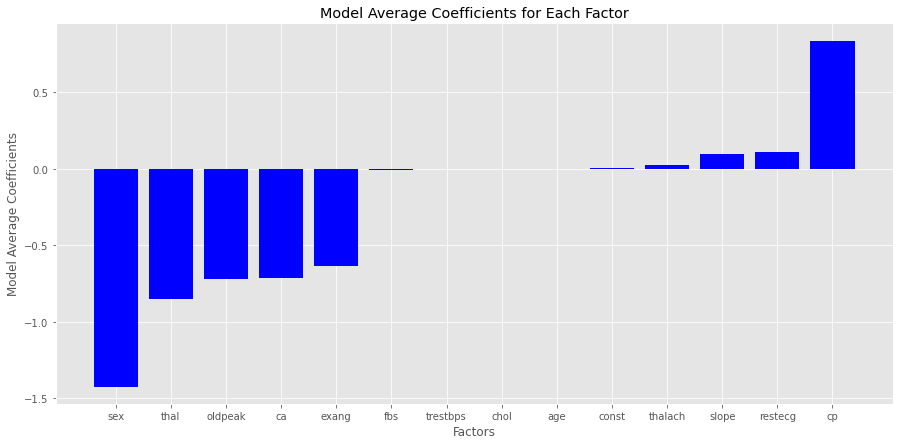

In [30]:
plt.style.use('ggplot')
plt.figure(figsize=(15,7))
x = result.summary().sort_values('Avg. Coefficient')['Variable Name']
coefs = result.summary().sort_values('Avg. Coefficient')['Avg. Coefficient']
x_pos = [i for i, _ in enumerate(x)]
plt.bar(x_pos,coefs,color = 'blue')
plt.xlabel("Factors")
plt.ylabel("Model Average Coefficients")
plt.title("Model Average Coefficients for Each Factor")
plt.xticks(x_pos,x)
plt.show()

In [11]:
result.likelihoods_all

{'(0,)': mpf('1.1757824356341367931575060443110160268161613789534241e-92'),
 '(1,)': mpf('5.2253341702752086368508686937535378896225585231172603e-93'),
 '(2,)': mpf('1.024719168640829532747564322305157516258232935228315e-92'),
 '(3,)': mpf('3.5093159681102662351102287090403029591172041615986127e-83'),
 '[0, 3]': mpf('1.5882753153664858715893494167276777584498089719179948e-80'),
 '[0, 8]': mpf('3.2129822397085201493460648926561935947221059590797898e-81'),
 '[0, 9]': mpf('6.3229805295755032332118837549028172935943084133941351e-81'),
 '[0, 10]': mpf('2.7025984576496223936788472609554886558870706104308103e-80'),
 '[1, 3]': mpf('3.4110742172019131806602275401262647323740640808895951e-79'),
 '[2, 3]': mpf('2.0618766232467925830812147848277073937432335426393553e-75'),
 '[3, 9]': mpf('2.0261090626682839932748849640189038790797338349115547e-74'),
 '[3, 10]': mpf('9.7654414181989174853692200578232567077144511407620936e-69'),
 '[0, 3, 10]': mpf('1.0442276221923206542451824859287198206129240184679

In [12]:
# predict the y-values from training input data
pred_BMA = result.predict(add_constant(X))
pred_Logit = log_reg.predict(add_constant(X))

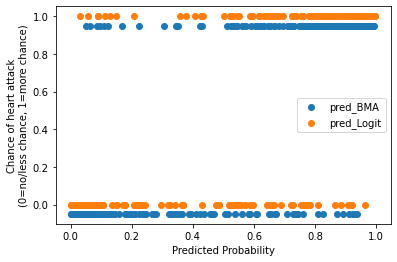

In [13]:
# plot the predictions with the actual values
import matplotlib.pyplot as plt
plt.scatter(pred_BMA,y-0.05)
plt.scatter(pred_Logit,y)
plt.xlabel("Predicted Probability")
plt.ylabel("Chance of heart attack\n(0=no/less chance, 1=more chance)")
plt.legend(['pred_BMA','pred_Logit'])

In [14]:
# compute accuracy
print("BMA Accuracy: ", np.sum((pred_BMA > 0.5) == y)/len(y))
print("Logit Accuracy: ", np.sum((pred_Logit > 0.5) == y)/len(y))

BMA Accuracy:  0.858085808580858
Logit Accuracy:  0.8514851485148515


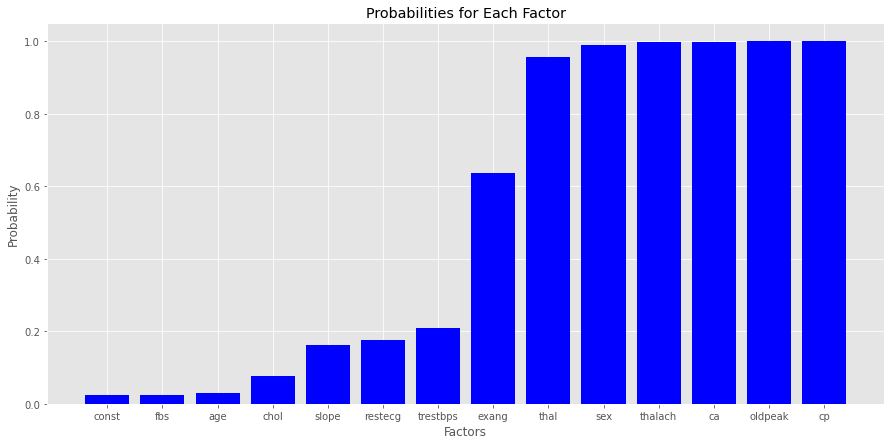

In [24]:
plt.style.use('ggplot')
plt.style.use('ggplot')
plt.figure(figsize=(15,7))
x = result.summary().sort_values('Probability')['Variable Name']
probs = result.summary().sort_values('Probability')['Probability']
x_pos = [i for i, _ in enumerate(x)]
plt.bar(x_pos,probs,color = 'blue')
plt.xlabel("Factors")
plt.ylabel("Probability")
plt.title("Probabilities for Each Factor")
plt.xticks(x_pos,x)
plt.show()






In [40]:
import sklearn.feature_selection

In [46]:
values = sklearn.feature_selection.f_classif(X, y)
values

(array([16.11669982, 25.79219115, 69.77227149,  6.45816867,  2.20298345,
         0.23694234,  5.77720891, 65.1201044 , 70.95243822, 68.55143941,
        40.90207063, 54.5598338 , 40.40769615]),
 array([7.52480130e-05, 6.67869212e-07, 2.46971211e-15, 1.15460592e-02,
        1.38790327e-01, 6.26777547e-01, 1.68398971e-02, 1.69733764e-14,
        1.52081384e-15, 4.08534639e-15, 6.10161062e-10, 1.49153874e-12,
        7.62487991e-10]))

In [51]:
stats = pd.DataFrame(values, columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal'], index = ['F-Statistic', 'P-val'])
stats


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
F-Statistic,16.116700,2.579219e+01,6.977227e+01,6.458169,2.202983,0.236942,5.777209,6.512010e+01,7.095244e+01,6.855144e+01,4.090207e+01,5.455983e+01,4.040770e+01
P-val,0.000075,6.678692e-07,2.469712e-15,0.011546,0.138790,0.626778,0.016840,1.697338e-14,1.520814e-15,4.085346e-15,6.101611e-10,1.491539e-12,7.624880e-10


In [59]:
X_new = X
X_new = X_new.drop(['chol','fbs'],axis = 1)
X_new

,age,sex,cp,trestbps,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,3,145,0,150,0,2.3,0,0,1
1,37,1,2,130,1,187,0,3.5,0,0,2
2,41,0,1,130,0,172,0,1.4,2,0,2
3,56,1,1,120,1,178,0,0.8,2,0,2
4,57,0,0,120,1,163,1,0.6,2,0,2
...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,1,123,1,0.2,1,0,3
299,45,1,3,110,1,132,0,1.2,1,0,3
300,68,1,0,144,1,141,0,3.4,1,2,3
301,57,1,0,130,1,115,1,1.2,1,1,3


In [60]:
values = sklearn.feature_selection.f_classif(X_new, y)
stats_new = pd.DataFrame(values, columns = ['age', 'sex', 'cp','trestbps', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal'], index = ['F-Statistic', 'P-val'])
stats_new


,age,sex,cp,trestbps,restecg,thalach,exang,oldpeak,slope,ca,thal
F-Statistic,16.116700,2.579219e+01,6.977227e+01,6.458169,5.777209,6.512010e+01,7.095244e+01,6.855144e+01,4.090207e+01,5.455983e+01,4.040770e+01
P-val,0.000075,6.678692e-07,2.469712e-15,0.011546,0.016840,1.697338e-14,1.520814e-15,4.085346e-15,6.101611e-10,1.491539e-12,7.624880e-10
